In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm, tree
import xgboost

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [3]:
# Load Data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Concatenate train & test
target = train['Survived']
dataset = [train,test]


In [4]:
print("Training Dataset:", train.shape)
print("Testing Dataset:", test.shape)

Training Dataset: (891, 12)
Testing Dataset: (418, 11)


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000


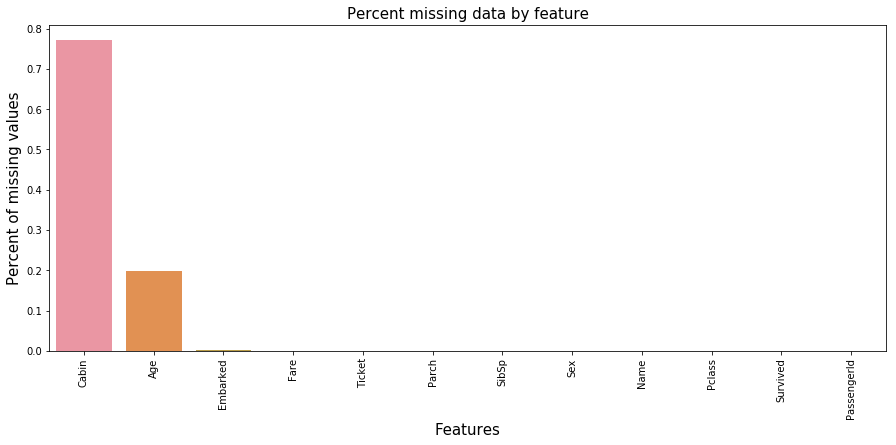

In [6]:
# Missing Features in Combined Dataset
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()

In [7]:
# Distribution of numerical feature values
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# Distribution for categorical feature values 
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Bradley, Mr. George (""George Arthur Brayton"")",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [9]:
# Correlationb between PClass and Survived 
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
# Correlation between Sex and Survived 
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
# Correlation between Siblings Spouse and Survived
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
#Correlation between Parch and Survived 
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


**Visualization of Data**

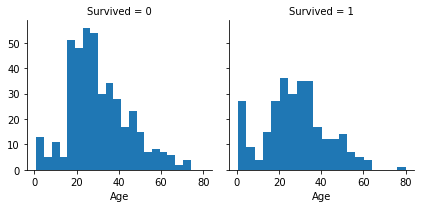

In [13]:
graph = sns.FacetGrid(train, col='Survived')
graph.map(plt.hist, 'Age', bins=20)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


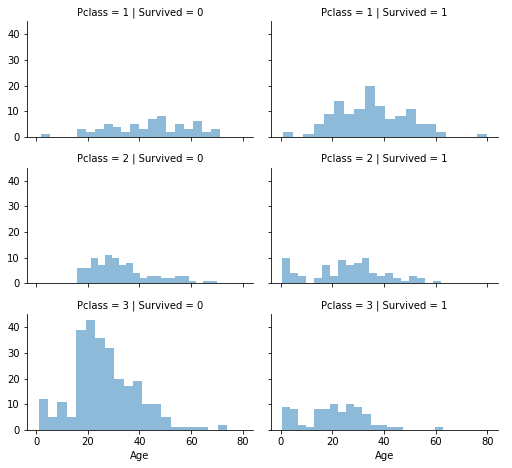

In [14]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


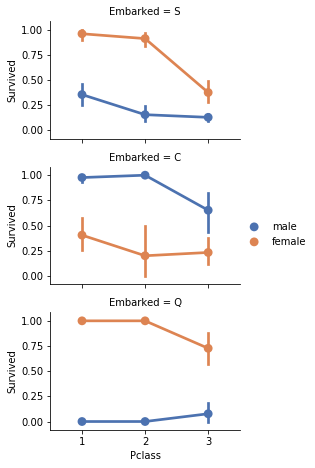

In [15]:
grid = sns.FacetGrid(train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


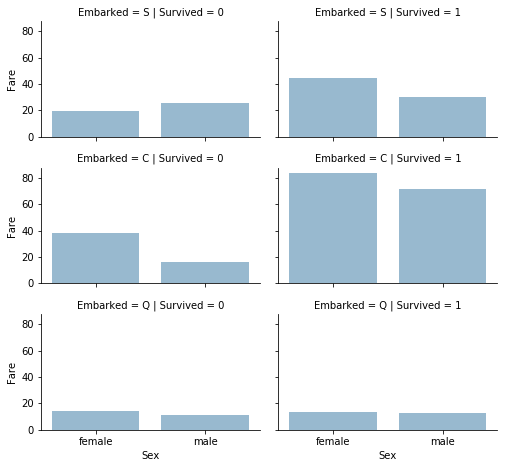

In [16]:
grid = sns.FacetGrid(train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

Wrangle the data

In [17]:
print("Before", train.shape, test.shape, dataset[0].shape, dataset[1].shape)

train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
dataset = [train, test]

"After", train.shape, test.shape, dataset[0].shape, dataset[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [18]:
for data in dataset:
    data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [19]:
for data in dataset:
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


Convert the categorical data to ordinal

In [21]:
#Mapping of title feature 
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for data in dataset:
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now I can safely drop the NAME and PASSENGERID feature from the training and testing dataset. 

In [22]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
dataset = [train, test]
train.shape, test.shape

((891, 9), (418, 9))

In [23]:
for data in dataset:
    data['Sex'] = data['Sex'].map({ 'female':1, 'male':0 })
    
train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [24]:
#Randomly fill the missing values with values close to the mean value but within one standard deviation
#Age in testing dataset
Column_Name_avg = test['Age'].mean()
Column_Name_std = test['Age'].std()
Column_Name_null_count = test['Age'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
test['Age'][np.isnan(test['Age'])] = Column_Name_null_random_list
test['Age'] = test['Age'].astype(int)

#Randomly fill the missing values with values close to the mean value but within one standard deviation
#Age in training dataset
Column_Name_avg = train['Age'].mean()
Column_Name_std = train['Age'].std()
Column_Name_null_count = train['Age'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
train['Age'][np.isnan(train['Age'])] = Column_Name_null_random_list
train['Age'] = train['Age'].astype(int)

train.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [25]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
Title       0
dtype: int64

In [26]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.539130
1,"(16.0, 32.0]",0.347418
2,"(32.0, 48.0]",0.374074
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [27]:
for data in dataset:    
    data.loc[ data['Age'] <= 16, 'Age'] = 0
    data.loc[(data['Age'] > 16) & (data['Age'] <= 32), 'Age'] = 1
    data.loc[(data['Age'] > 32) & (data['Age'] <= 48), 'Age'] = 2
    data.loc[(data['Age'] > 48) & (data['Age'] <= 64), 'Age'] = 3
    data.loc[ data['Age'] > 64, 'Age']
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [28]:
train = train.drop(['AgeBand'], axis=1)
dataset = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


In [29]:
for data in dataset:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [30]:
for data in dataset:
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [31]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
dataset = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [32]:
freq_embarked = train.Embarked.dropna().mode()[0]

for data in dataset:
    data['Embarked'] = data['Embarked'].fillna(freq_embarked)
    
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [33]:
for data in dataset:
    data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,0,1,0
1,1,1,1,2,71.2833,1,3,0
2,1,3,1,1,7.9250,0,2,1
3,1,1,1,2,53.1000,0,3,0
4,0,3,0,2,8.0500,0,1,1


In [34]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,7.8292,2,1,1
1,893,3,1,2,7.0000,0,3,0
2,894,2,0,3,9.6875,2,1,1
3,895,3,0,1,8.6625,0,1,1
4,896,3,1,1,12.2875,0,3,0


In [35]:
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [36]:
for data in dataset:
    data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare' ] = 1
    data.loc[(data['Fare'] > 14.54) & (data['Fare'] <= 31.0), 'Fare' ] = 2
    data.loc[(data['Fare'] > 31.0) & (data['Fare'] <= 512.329), 'Fare' ] = 3
    data['Fare'] = data['Fare'].astype(int)

train = train.drop(['FareBand'], axis=1)

dataset = [train, test]
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,0,1,0
1,1,1,1,2,3,1,3,0
2,1,3,1,1,1,0,2,1
3,1,1,1,2,3,0,3,0
4,0,3,0,2,1,0,1,1


In [37]:
test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,0,2,1,1
1,893,3,1,2,0,0,3,0
2,894,2,0,3,1,2,1,1
3,895,3,0,1,1,0,1,1
4,896,3,1,1,1,0,3,0
5,897,3,0,0,1,0,1,1
6,898,3,1,1,0,2,2,1
7,899,2,0,1,2,0,1,0
8,900,3,1,1,0,1,3,1
9,901,3,0,1,2,0,1,0


In [38]:
train_X = train.drop("Survived", axis=1)
train_Y = train["Survived"]
test_X  = test.drop("PassengerId", axis=1).copy()
train_X.shape, train_Y.shape, test_X.shape

((891, 7), (891,), (418, 7))

In [39]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(train_X, train_Y)
predY = svc.predict(test_X)
acc_svc = round(svc.score(train_X, train_Y) * 100, 2)
acc_svc

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


83.95

In [40]:
# Random Forrest Classification
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X, train_Y)
predY = random_forest.predict(test_X)

random_forest.score(train_X, train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y) * 100, 2)
acc_random_forest

87.77

In [41]:
XG_Boost = xgboost.XGBClassifier()
XG_Boost.fit(train_X, train_Y)
predY = XG_Boost.predict(test_X)

XG_Boost.score(train_X, train_Y)
acc_xg_boost = round(XG_Boost.score(train_X, train_Y) * 100, 2)
acc_xg_boost


84.4

In [42]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train_X, train_Y)
Y_pred = gaussian.predict(test_X)
acc_gaussian = round(gaussian.score(train_X, train_Y) * 100, 2)
acc_gaussian


76.21

In [43]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_X, train_Y)
Y_pred = knn.predict(test_X)
acc_knn = round(knn.score(train_X, train_Y) * 100, 2)
acc_knn

85.63

In [44]:
# train with Gradient Boosting algorithm
# compute the accuracy scores on train and validation sets when training with different learning rates

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 3, random_state = 0)
    gb.fit(train_X, train_Y)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(train_X, train_Y)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.819

Learning rate:  0.1
Accuracy score (training): 0.828

Learning rate:  0.25
Accuracy score (training): 0.836

Learning rate:  0.5
Accuracy score (training): 0.844

Learning rate:  0.75
Accuracy score (training): 0.851

Learning rate:  1
Accuracy score (training): 0.847



In [45]:
# Output confusion matrix and classification report of Gradient Boosting algorithm on validation set

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.75, max_features=2, max_depth = 3, random_state = 0)
gb.fit(train_X, train_Y)
predY = gb.predict(test_X)

gb.score(train_X, train_Y)
acc_gb = round(gb.score(train_X, train_Y) * 100, 2)
acc_gb


85.07

In [46]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Random Forest', 'XG-Boost', 'Guassian Naive Bayes', 'KNN', 'Gradient Boosting'],
    'Score': [acc_svc, acc_random_forest, acc_xg_boost, acc_gaussian, acc_knn, acc_gb ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Random Forest,87.77
4,KNN,85.63
5,Gradient Boosting,85.07
2,XG-Boost,84.40
0,Support Vector Machines,83.95
3,Guassian Naive Bayes,76.21


In [47]:
val_preds = random_forest.predict(test_X)

In [48]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": val_preds
    })

submission.to_csv('submission.csv', index=False)

In [49]:
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
